# SleepUni Demo

This notebook demonstrates how to:
1. Load and preprocess example 30-second PSG epochs
2. Visualize 12-channel polysomnography signals
3. Load the pretrained ViT backbone
4. Forward input signals and obtain extracted embeddings

In [1]:
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

PROJECT_ROOT = os.path.abspath(".")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from osf.backbone.vit1d_cls import vit_base

## Configuration

The pretrained model expects **12 PSG channels** at **64 Hz** in **30-second** epochs.

In [2]:
CHANNEL_NAMES = [
    "ECG", "EMG_Chin", "EMG_LLeg", "EMG_RLeg",
    "ABD", "THX", "NP", "SN",
    "EOG_E1_A2", "EOG_E2_A1", "EEG_C3_A2", "EEG_C4_A1",
]
NUM_CHANNELS = len(CHANNEL_NAMES)  # 12
SAMPLE_RATE  = 64
EPOCH_SEC    = 30
SEQ_LEN      = SAMPLE_RATE * EPOCH_SEC  # 1920

EXAMPLE_DIR  = os.path.join(PROJECT_ROOT, "example_data")
WEIGHTS_PATH = os.path.join(PROJECT_ROOT, "pretrained_weights", "dino_vit_base_backbone.pth")
EPOCH_IDS    = [595, 596, 597, 598]

## 1. Load and preprocess example PSG epochs

Each epoch is a Parquet file with multi-rate channels (ECG at 128 Hz, EEG/EOG at 64 Hz, respiratory at 8 Hz, etc.).  
We resample all channels to 64 Hz via linear interpolation, zero-fill missing channels, and clamp to `[-6, 6]`.

In [3]:
def load_and_preprocess_epoch(parquet_path):
    df = pd.read_parquet(parquet_path)
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.floating):
            try:
                df[c] = df[c].astype(np.float32)
            except Exception:
                pass

    src_hz = len(df) / EPOCH_SEC
    if not np.issubdtype(df.index.dtype, np.number):
        df.index = np.arange(len(df)) / src_hz
    t0 = float(df.index.min())
    t1 = float(df.index.max())
    t_target = np.arange(t0, t0 + EPOCH_SEC, 1.0 / SAMPLE_RATE)
    t_target = t_target[t_target <= t1 + 1e-9]
    df = df.reindex(t_target).interpolate(method="linear", limit_direction="both").fillna(0.0)

    out = {}
    for ch in CHANNEL_NAMES:
        out[ch] = df[ch].values.astype(np.float32) if ch in df.columns else np.zeros(len(df), dtype=np.float32)
    arr = np.stack([out[ch] for ch in CHANNEL_NAMES], axis=0)

    if arr.shape[1] < SEQ_LEN:
        arr = np.pad(arr, ((0, 0), (0, SEQ_LEN - arr.shape[1])))
    elif arr.shape[1] > SEQ_LEN:
        arr = arr[:, :SEQ_LEN]
    return torch.tensor(np.clip(arr, -6, 6), dtype=torch.float32)

In [4]:
epochs = []
for eid in EPOCH_IDS:
    fp = os.path.join(EXAMPLE_DIR, f"epoch-{eid:05d}_all.parquet")
    epochs.append(load_and_preprocess_epoch(fp))
    print(f"Loaded epoch {eid} → {list(epochs[-1].shape)}")

x_batch = torch.stack(epochs, dim=0)
print(f"\nBatch: {list(x_batch.shape)}  (B, C, T)")

Loaded epoch 595 → [12, 1920]
Loaded epoch 596 → [12, 1920]
Loaded epoch 597 → [12, 1920]
Loaded epoch 598 → [12, 1920]

Batch: [4, 12, 1920]  (B, C, T)


## 2. Visualize 12-channel PSG

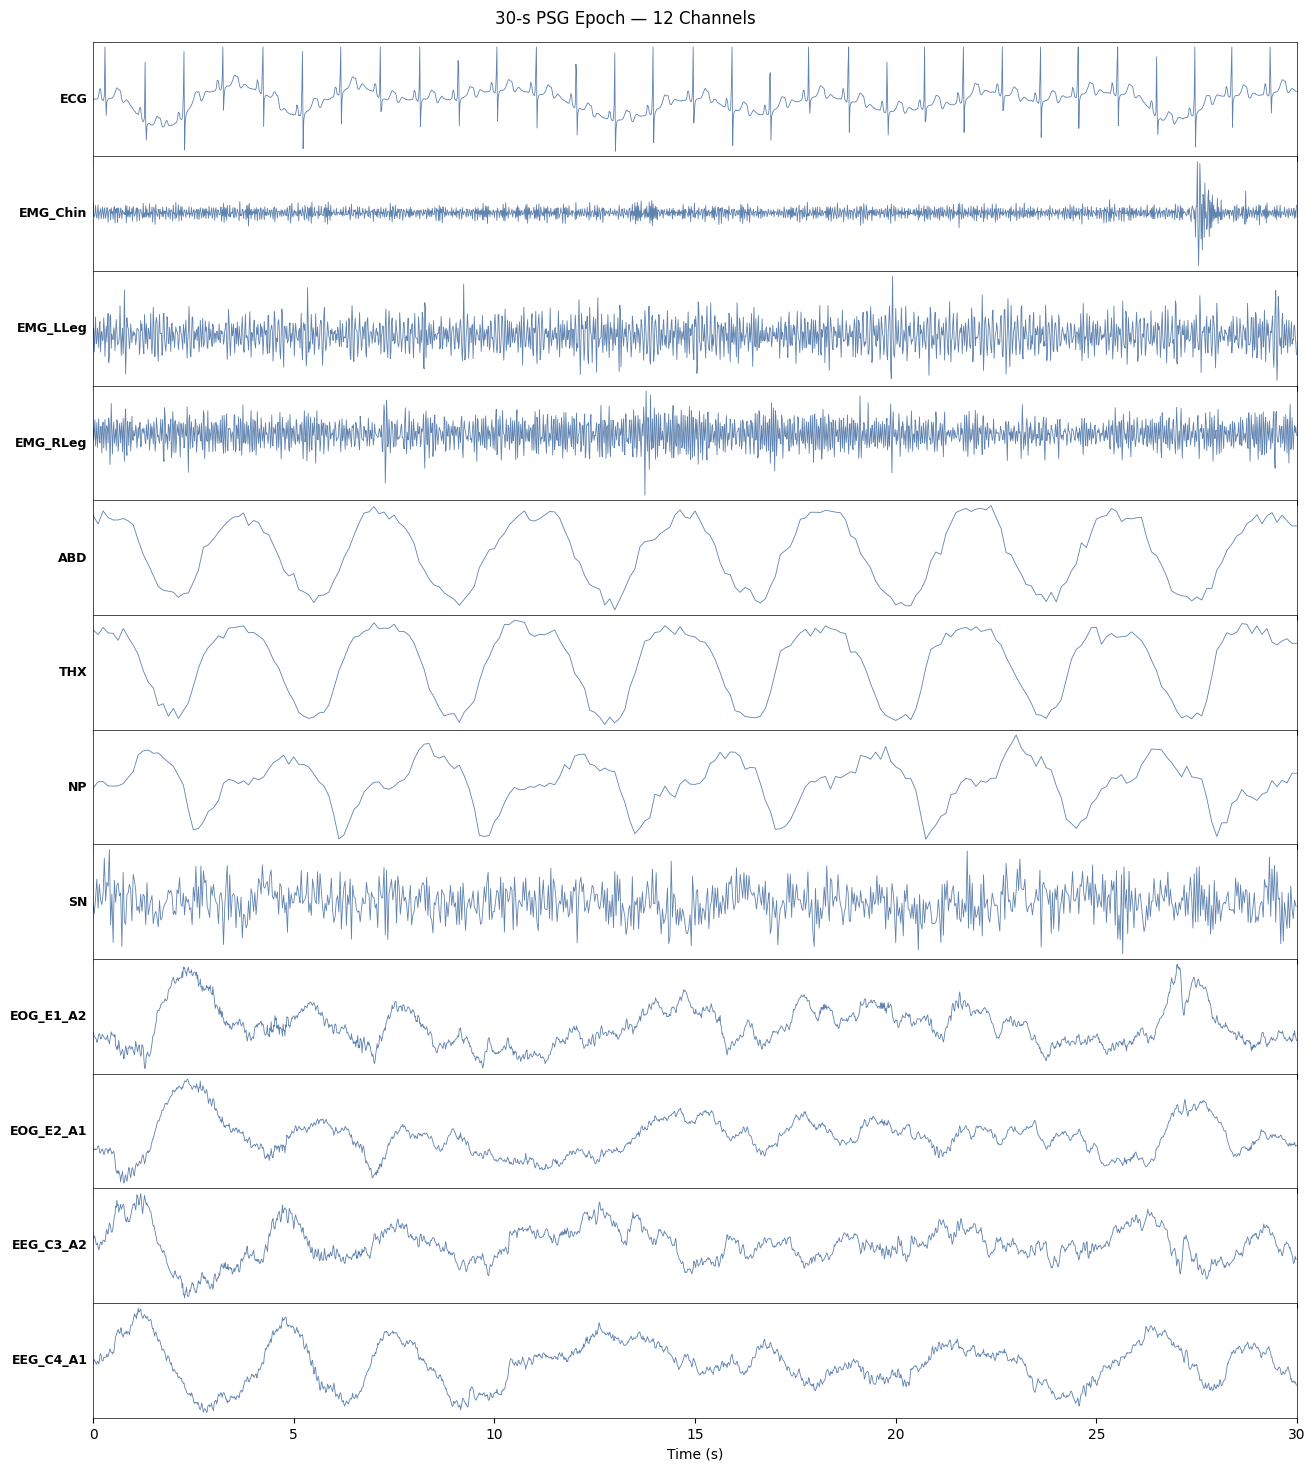

In [5]:
COLOR = (95/255, 130/255, 175/255)
time_axis = np.arange(SEQ_LEN) / SAMPLE_RATE

fig, axes = plt.subplots(NUM_CHANNELS, 1, figsize=(14, 16), sharex=True,
                         gridspec_kw={"hspace": 0})
for i, (ch, ax) in enumerate(zip(CHANNEL_NAMES, axes)):
    ax.plot(time_axis, x_batch[0, i].numpy(), color=COLOR, linewidth=0.6)
    ax.set_ylabel(ch, rotation=0, ha="right", va="center", fontsize=9, fontweight="bold")
    ax.set_yticks([])
    ax.set_xlim(0, EPOCH_SEC)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

axes[-1].set_xlabel("Time (s)", fontsize=10)
fig.suptitle("30-s PSG Epoch — 12 Channels", fontsize=12, y=0.92)
fig.subplots_adjust(left=0.12, right=0.98, top=0.90, bottom=0.04, hspace=0)
plt.show()

## 3. Load pretrained ViT backbone

**ViT-Base** with 2D patchify: `patch_ch=4` × `patch_time=64` → 3 channel groups × 30 time patches = **90 tokens** + 1 CLS token.

In [6]:
payload  = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
meta     = payload["metadata"]

backbone = vit_base(
    num_leads=meta["num_leads"],
    seq_len=meta["seq_len"],
    patch_size=meta["patch_size_time"],
    lead_wise=meta["lead_wise"],
    patch_size_ch=meta["patch_size_ch"],
)
backbone.load_state_dict(payload["state_dict"], strict=True)
backbone.eval()

n_params = sum(p.numel() for p in backbone.parameters())
print(f"ViT-Base loaded — {n_params / 1e6:.2f} M params")
print(f"Config: {meta}")

ViT-Base loaded — 85.33 M params
Config: {'model_name': 'dino', 'encoder_name': 'vit_base', 'num_leads': 12, 'patch_size_time': 64, 'patch_size_ch': 4, 'lead_wise': 1, 'sample_rate': 64, 'window_size_sec': 30, 'seq_len': 1920, 'width': 768, 'depth': 12}


## 4. Extract embeddings

- **CLS token** `[B, 768]`
- **Patch tokens** `[B, 90, 768]`

In [7]:
with torch.no_grad():
    cls_embs, patch_embs = backbone.forward_encoding(x_batch, return_sequence=False)

cls_normed = F.normalize(cls_embs, dim=-1)

print(f"CLS embeddings   : {list(cls_embs.shape)}")
print(f"Patch embeddings : {list(patch_embs.shape)}")



CLS embeddings   : [4, 768]
Patch embeddings : [4, 90, 768]
